In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Optional: pretty settings
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


In [2]:
sample_n = 50000  # adjust smaller if needed

logon = pd.read_csv(r"C:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\r4.2\logon.csv", 
                    nrows=sample_n, parse_dates=["date"])

device = pd.read_csv(r"C:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\r4.2\device.csv", 
                     nrows=sample_n, parse_dates=["date"])

psych = pd.read_csv(r"C:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\r4.2\psychometric.csv")  # small file



In [3]:
# 4️⃣ Store datasets in a dictionary for easy looping
datasets = {
    "logon": logon,
    "device": device,
    "psychometric": psych
}

# 5️⃣ Quick check of shapes and sample rows
for name, df in datasets.items():
    print(f"\n{name.upper()} dataset:")
    print("Shape:", df.shape)
    print(df.head(3))


LOGON dataset:
Shape: (50000, 5)
                         id                date     user       pc activity
0  {X1D9-S0ES98JV-5357PWMI} 2010-01-02 06:49:00  NGF0157  PC-6056    Logon
1  {G2B3-L6EJ61GT-2222RKSO} 2010-01-02 06:50:00  LRR0148  PC-4275    Logon
2  {U6Q3-U0WE70UA-3770UREL} 2010-01-02 06:53:04  LRR0148  PC-4124    Logon

DEVICE dataset:
Shape: (50000, 5)
                         id                date     user       pc    activity
0  {J1S3-L9UU75BQ-7790ATPL} 2010-01-02 07:21:06  MOH0273  PC-6699     Connect
1  {N7B5-Y7BB27SI-2946PUJK} 2010-01-02 07:37:41  MOH0273  PC-6699  Disconnect
2  {U1V9-Z7XT67KV-5649MYHI} 2010-01-02 07:59:11  HPH0075  PC-2417     Connect

PSYCHOMETRIC dataset:
Shape: (1000, 7)
             employee_name  user_id   O   C   E   A   N
0         Calvin Edan Love  CEL0561  40  39  36  19  40
1  Christine Reagan Deleon  CRD0624  26  22  17  39  32
2    Jade Felicia Caldwell  JFC0557  22  16  23  40  33


In [15]:
# Function to check info, describe, nulls, and datetime columns
def general_checks(df, name):
    print(f"\n{name.upper()} DATASET INFO")
    print(df.info())
    
    print("\nDESCRIBE (all non-datetime columns):")
    print(df.describe(include="all"))
    
    # Summarize datetime columns separately
    datetime_cols = df.select_dtypes(include=["datetime"])
    if not datetime_cols.empty:
        print("\nDATETIME SUMMARY:")
        for col in datetime_cols.columns:
            print(f"{col}: min={df[col].min()}, max={df[col].max()}, unique={df[col].nunique()}")
    
    print("\nNull values:\n", df.isnull().sum())

# Run checks on all three datasets
for name, df in datasets.items():
    general_checks(df, name)



LOGON DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        50000 non-null  object        
 1   date      50000 non-null  datetime64[ns]
 2   user      50000 non-null  object        
 3   pc        50000 non-null  object        
 4   activity  50000 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.9+ MB
None

DESCRIBE (all non-datetime columns):
                              id                        date     user  \
count                      50000                       50000    50000   
unique                     50000                         NaN     1000   
top     {X1D9-S0ES98JV-5357PWMI}                         NaN  BSS0369   
freq                           1                         NaN      196   
mean                         NaN  2010-01-16 02:11:48.906560      NaN   
min       

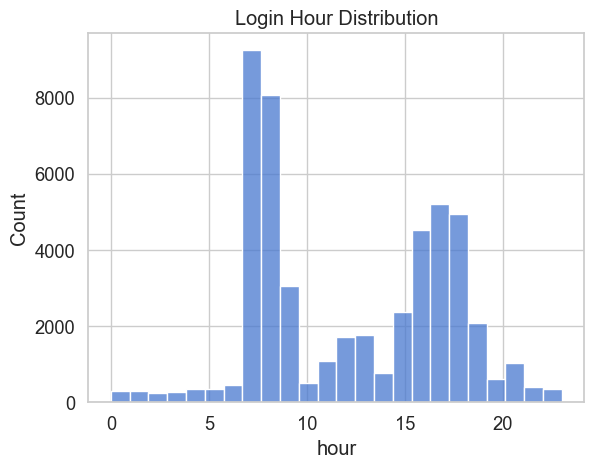

After-hours logins: 24080
         user       pc  count
1237  HAD0246  PC-0926     88
813   CTR0341  PC-6184     80
3158  SSJ0784  PC-0840     79
217   ATE0869  PC-1313     78
2285  LBF0214  PC-3819     77
1509  IRM0931  PC-7188     77
998   EHB0420  PC-1586     77
2225  LAP0338  PC-5758     75
448   BRB0355  PC-9896     73
1254  HDD0806  PC-6032     73


In [5]:
# 1️⃣ Login hour distribution
logon['hour'] = logon['date'].dt.hour
sns.histplot(logon['hour'], bins=24, kde=False)
plt.title("Login Hour Distribution")
plt.show()

# 2️⃣ After-hours logins (<9 or >18)
after_hours = logon[(logon['hour'] < 9) | (logon['hour'] > 18)]
print("After-hours logins:", after_hours.shape[0])

# 3️⃣ Cross-PC logins
cross_pc = logon.groupby(['user', 'pc']).size().reset_index(name='count')
print(cross_pc.sort_values('count', ascending=False).head(10))


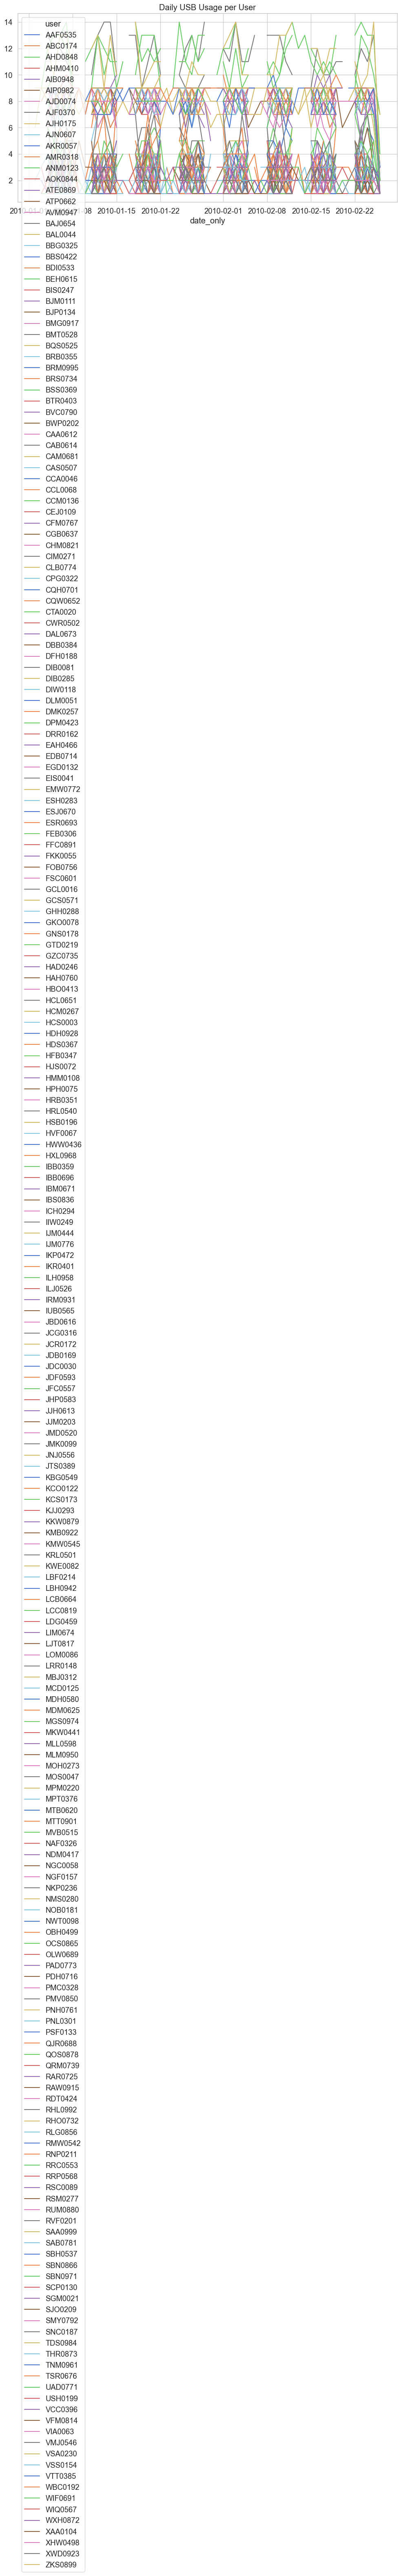

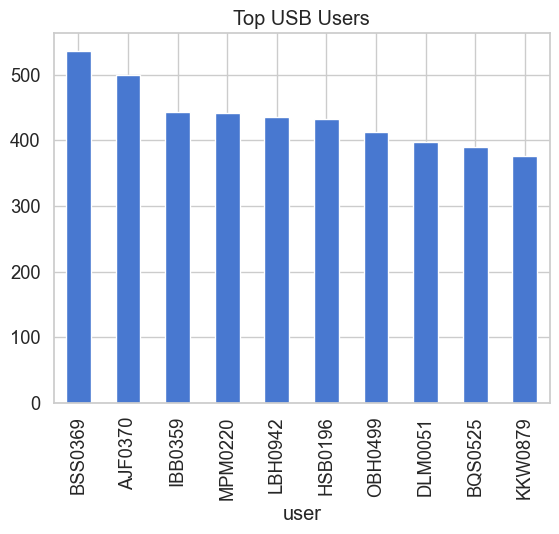

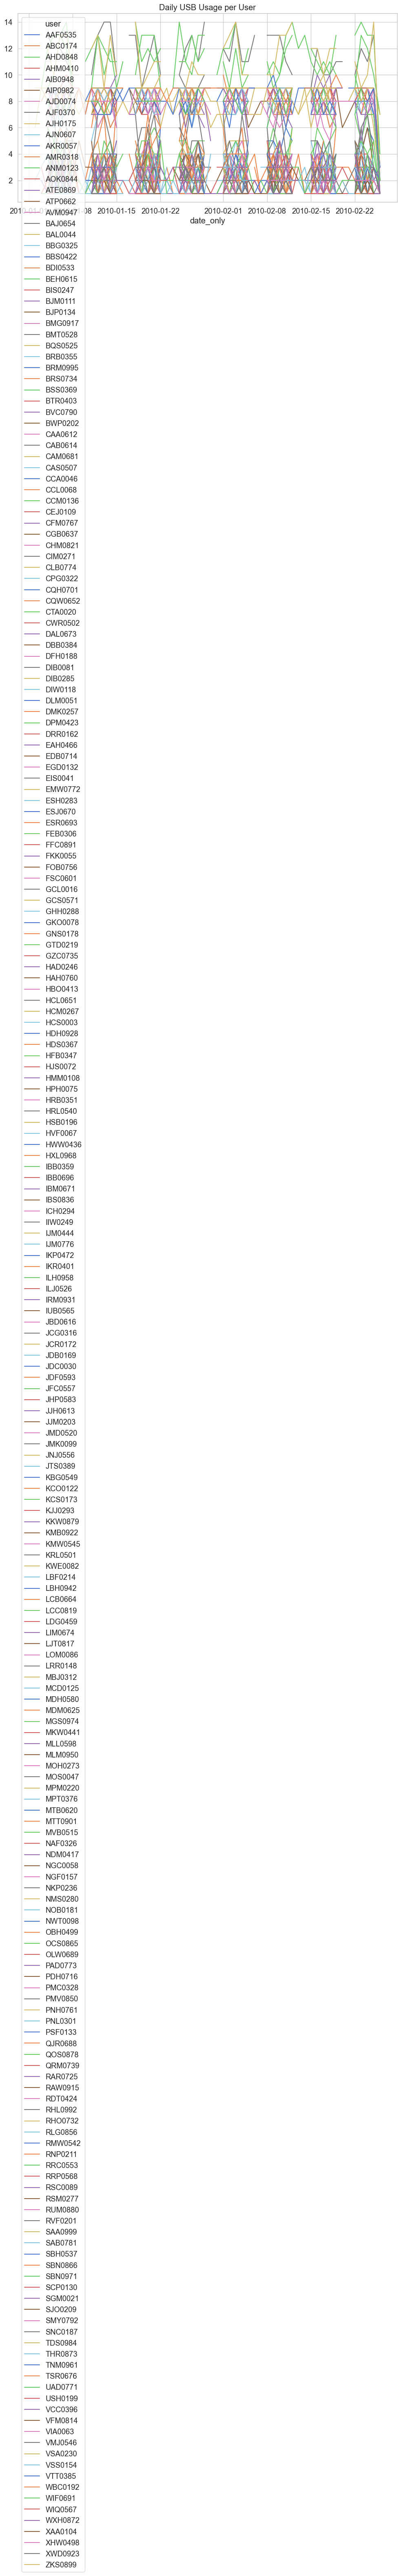

In [6]:
# Add date_only column first
device['date_only'] = device['date'].dt.date

# Filter USB connect events
usb_users = device[device['activity'].str.contains("connect", na=False)]

# Group by user and date_only
daily_usb = usb_users.groupby(['user', 'date_only']).size()
daily_usb.unstack(0).plot(figsize=(12,6))
plt.title("Daily USB Usage per User")
plt.show()

# 1️⃣ USB usage per user
usb_users = device[device['activity'].str.contains("connect", na=False)]
usb_counts = usb_users['user'].value_counts()
usb_counts.head(10).plot(kind='bar')
plt.title("Top USB Users")
plt.show()

# 2️⃣ Daily USB spikes
device['date_only'] = device['date'].dt.date
daily_usb = usb_users.groupby(['user', 'date_only']).size()
daily_usb.unstack(0).plot(figsize=(12,6))
plt.title("Daily USB Usage per User")
plt.show()


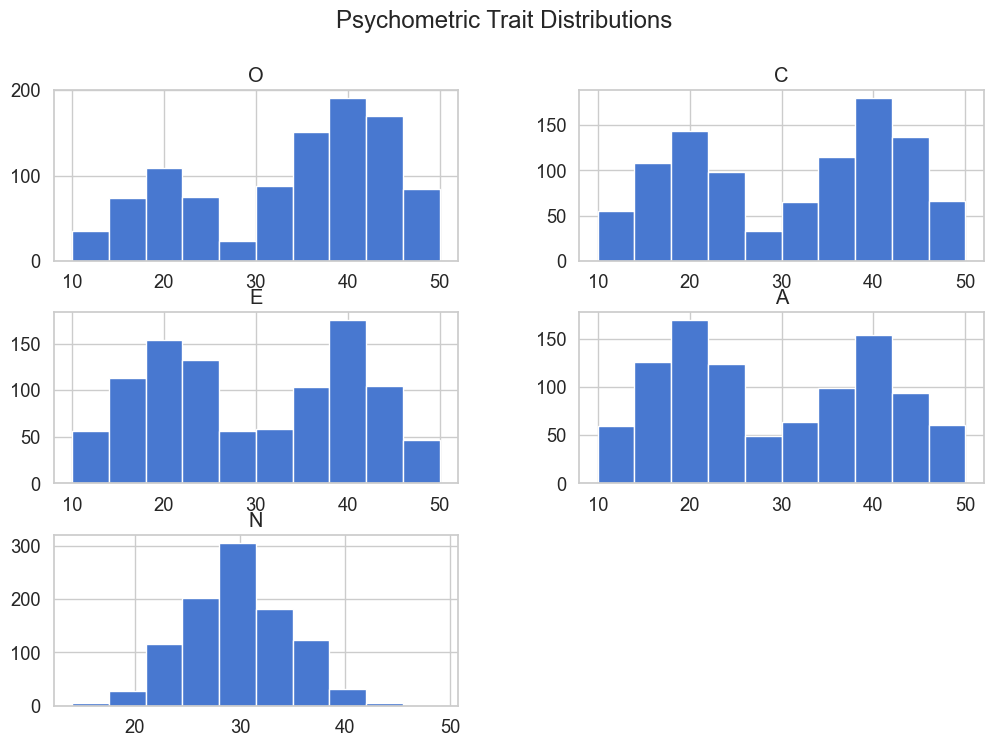

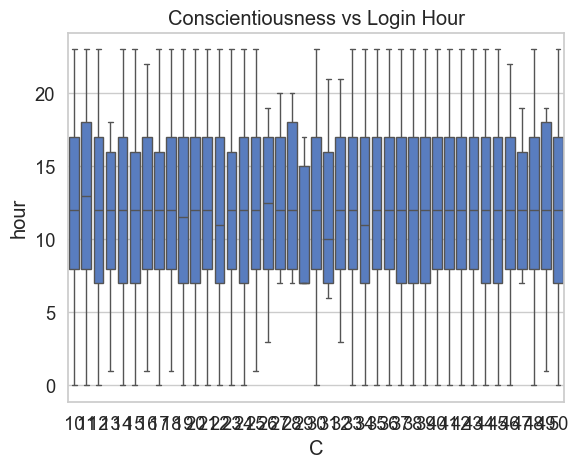

In [7]:
# 1️⃣ Distribution of Big 5 traits
psych.hist(figsize=(12,8))
plt.suptitle("Psychometric Trait Distributions")
plt.show()

# 2️⃣ Example: Conscientiousness vs login hour
logon_psych = logon.merge(psych, left_on='user', right_on='user_id', how='left')
sns.boxplot(x='C', y='hour', data=logon_psych)
plt.title("Conscientiousness vs Login Hour")
plt.show()


In [8]:
logon['date_only'] = logon['date'].dt.date
logon_counts = logon.groupby(['user', 'date_only']).size().reset_index(name='logon_count')
logon_counts.head()


,user,date_only,logon_count
0,AAE0190,2010-01-04,2
1,AAE0190,2010-01-05,2
2,AAE0190,2010-01-06,2
3,AAE0190,2010-01-07,2
4,AAE0190,2010-01-08,2


In [9]:
logon['after_hours'] = ((logon['hour'] < 9) | (logon['hour'] > 18)).astype(int)
after_hours_counts = logon.groupby('user')['after_hours'].sum().reset_index(name='after_hours_count')
after_hours_counts.head()


,user,after_hours_count
0,AAE0190,19
1,AAF0535,10
2,AAF0791,19
3,AAL0706,19
4,AAM0658,18


In [10]:
cross_pc_counts = logon.groupby('user')['pc'].nunique().reset_index(name='unique_pcs')
cross_pc_counts.head()


,user,unique_pcs
0,AAE0190,1
1,AAF0535,1
2,AAF0791,1
3,AAL0706,1
4,AAM0658,1


In [11]:
device['date_only'] = device['date'].dt.date  # ensure this exists
usb_users = device[device['activity'].str.contains("connect", na=False)]
usb_counts_daily = usb_users.groupby(['user', 'date_only']).size().reset_index(name='usb_count')
usb_counts_daily.head()


,user,date_only,usb_count
0,AAF0535,2010-01-05,2
1,AAF0535,2010-01-06,1
2,AAF0535,2010-01-07,2
3,AAF0535,2010-01-08,4
4,AAF0535,2010-01-11,1


In [12]:
usb_mean = usb_counts_daily.groupby('user')['usb_count'].mean().reset_index(name='mean_usb')
usb_std = usb_counts_daily.groupby('user')['usb_count'].std().reset_index(name='std_usb')

usb_stats = usb_mean.merge(usb_std, on='user')
usb_counts_daily = usb_counts_daily.merge(usb_stats, on='user')
usb_counts_daily['usb_zscore'] = (usb_counts_daily['usb_count'] - usb_counts_daily['mean_usb']) / usb_counts_daily['std_usb']

# Flag unusual spikes
usb_counts_daily['usb_spike'] = (usb_counts_daily['usb_zscore'] > 2).astype(int)
usb_counts_daily.head()


,user,date_only,usb_count,mean_usb,std_usb,usb_zscore,usb_spike
0,AAF0535,2010-01-05,2,2.0,0.8044,0.000000,0
1,AAF0535,2010-01-06,1,2.0,0.8044,-1.243163,0
2,AAF0535,2010-01-07,2,2.0,0.8044,0.000000,0
3,AAF0535,2010-01-08,4,2.0,0.8044,2.486326,1
4,AAF0535,2010-01-11,1,2.0,0.8044,-1.243163,0


In [13]:
# Merge logon counts, after_hours, cross_pc
features = logon_counts.merge(after_hours_counts, on='user', how='left')
features = features.merge(cross_pc_counts, on='user', how='left')

# Merge USB spikes
usb_daily_sum = usb_counts_daily.groupby('user')['usb_spike'].sum().reset_index(name='usb_spike_count')
features = features.merge(usb_daily_sum, on='user', how='left')

# Merge psychometric traits
features = features.merge(psych, left_on='user', right_on='user_id', how='left')

features.head()


,user,date_only,logon_count,after_hours_count,unique_pcs,usb_spike_count,employee_name,user_id,O,C,E,A,N
0,AAE0190,2010-01-04,2,19,1,NaN,August Armando Evans,AAE0190,36,30,14,50,29
1,AAE0190,2010-01-05,2,19,1,NaN,August Armando Evans,AAE0190,36,30,14,50,29
2,AAE0190,2010-01-06,2,19,1,NaN,August Armando Evans,AAE0190,36,30,14,50,29
3,AAE0190,2010-01-07,2,19,1,NaN,August Armando Evans,AAE0190,36,30,14,50,29
4,AAE0190,2010-01-08,2,19,1,NaN,August Armando Evans,AAE0190,36,30,14,50,29


In [14]:
# Simple threshold-based anomaly detection
features['anomaly_flag'] = 0

# Example rules
features.loc[features['after_hours_count'] > features['after_hours_count'].mean() + 2*features['after_hours_count'].std(), 'anomaly_flag'] = 1
features.loc[features['usb_spike_count'] > features['usb_spike_count'].mean() + 2*features['usb_spike_count'].std(), 'anomaly_flag'] = 1
features.loc[features['unique_pcs'] > features['unique_pcs'].mean() + 2*features['unique_pcs'].std(), 'anomaly_flag'] = 1

# Check anomalies
features[features['anomaly_flag'] == 1].head()


,user,date_only,logon_count,after_hours_count,unique_pcs,usb_spike_count,employee_name,user_id,O,C,E,A,N,anomaly_flag
270,ACC0042,2010-01-04,6,108,53,NaN,Alfonso Colin Cooley,ACC0042,23,19,37,20,31,1
271,ACC0042,2010-01-05,12,108,53,NaN,Alfonso Colin Cooley,ACC0042,23,19,37,20,31,1
272,ACC0042,2010-01-06,6,108,53,NaN,Alfonso Colin Cooley,ACC0042,23,19,37,20,31,1
273,ACC0042,2010-01-07,6,108,53,NaN,Alfonso Colin Cooley,ACC0042,23,19,37,20,31,1
274,ACC0042,2010-01-08,6,108,53,NaN,Alfonso Colin Cooley,ACC0042,23,19,37,20,31,1


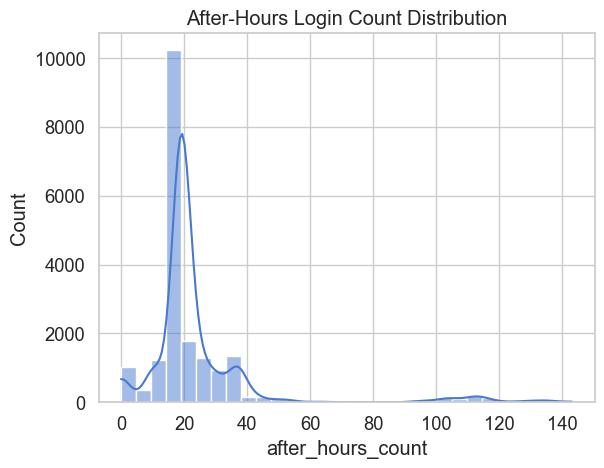

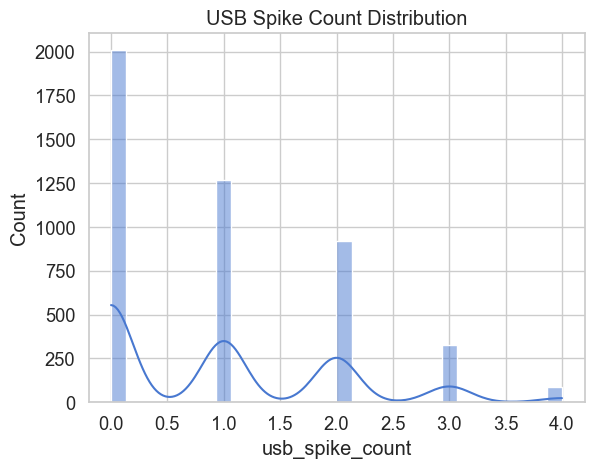

In [15]:
sns.histplot(features['after_hours_count'], bins=30, kde=True)
plt.title("After-Hours Login Count Distribution")
plt.show()

sns.histplot(features['usb_spike_count'], bins=30, kde=True)
plt.title("USB Spike Count Distribution")
plt.show()


In [18]:
import pandas as pd

# Load limited samples for performance
logon = pd.read_csv("r4.2/logon.csv", parse_dates=["date"], nrows=50000)
device = pd.read_csv("r4.2/device.csv", parse_dates=["date"], nrows=50000)
psych = pd.read_csv("r4.2/psychometric.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'r4.2/logon.csv'

In [19]:
import os
print(os.getcwd())


c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook


In [21]:
import pandas as pd

logon = pd.read_csv("../r4.2/logon.csv", parse_dates=["date"], nrows=50000)
device = pd.read_csv("../r4.2/device.csv", parse_dates=["date"], nrows=50000)
psych = pd.read_csv("../r4.2/psychometric.csv")


In [24]:
# 1. Logon features
logon['hour'] = logon['date'].dt.hour
logon['date_only'] = logon['date'].dt.date
logon_features = logon.groupby("user").agg(
    total_logins=("user", "count"),
    unique_days=("date_only", "nunique"),
    after_hours=("hour", lambda x: ((x < 8) | (x > 18)).sum()),
    unique_machines=("pc", "nunique")
).reset_index()

# 2. Device features
device['date_only'] = device['date'].dt.date
usb_users = device[device["activity"] == "connect"]
device_features = usb_users.groupby("user").agg(
    usb_count=("user", "count"),
    usb_days=("date_only", "nunique")
).reset_index()

# 3. Merge with psychometric
user_features = logon_features.merge(device_features, on="user", how="left")
user_features = user_features.merge(psych, left_on="user", right_on="user_id", how="left")
user_features = user_features.fillna(0)

In [25]:
user_features.to_csv("user_features.csv", index=False)
print("Saved user_features.csv in R4.2 folder ✅")


Saved user_features.csv in R4.2 folder ✅


In [26]:
print(user_features.head())
print(user_features.shape)


      user  total_logins  unique_days  after_hours  unique_machines  \
0  AAE0190            37           19            0                1   
1  AAF0535            37           19            0                1   
2  AAF0791            37           19            0                1   
3  AAL0706            37           19           19                1   
4  AAM0658            37           19           18                1   

   usb_count  usb_days          employee_name  user_id   O   C   E   A   N  
0        0.0       0.0   August Armando Evans  AAE0190  36  30  14  50  29  
1        0.0       0.0  Athena Amelia Foreman  AAF0535  17  21  36  33  31  
2        0.0       0.0  Aladdin Abraham Foley  AAF0791  14  40  40  50  34  
3        0.0       0.0       April Alika Levy  AAL0706  37  14  28  13  25  
4        0.0       0.0       Abel Adam Morton  AAM0658  43  35  37  36  22  
(1000, 14)
